In [1]:
# importamos la libreria a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split,  GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [2]:
uber = pd.read_csv('../source/ncr_ride_bookings.csv')
uber.sample(5)

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
119605,2024-08-18,08:43:43,"""CNR1757593""",Completed,"""CID1398956""",Premier Sedan,Moti Nagar,Uttam Nagar,13.0,25.1,...,NaN,NaN,NaN,NaN,NaN,118.0,41.01,5.0,4.2,Cash
18217,2024-09-07,17:31:15,"""CNR5088633""",Completed,"""CID4842744""",Bike,Kalkaji,Anand Vihar,4.9,18.7,...,NaN,NaN,NaN,NaN,NaN,610.0,7.49,4.6,4.8,UPI
45678,2024-10-07,19:22:26,"""CNR8392019""",Cancelled by Driver,"""CID4787931""",Auto,Sushant Lok,Sarai Kale Khan,3.6,NaN,...,NaN,1.0,Customer related issue,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138869,2024-09-03,20:13:39,"""CNR7261866""",Completed,"""CID9792814""",Go Mini,Govindpuri,Jhilmil,2.2,41.8,...,NaN,NaN,NaN,NaN,NaN,388.0,17.79,4.3,4.8,Cash
121965,2024-07-21,12:49:05,"""CNR7792685""",Completed,"""CID5690234""",eBike,Nawada,Kadarpur,2.4,40.3,...,NaN,NaN,NaN,NaN,NaN,102.0,11.75,4.9,4.2,UPI


In [3]:
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reason for cancelling by Customer  1050

In [4]:
#Validamos valores duplicados
print('Validamos si hay valores duplicados a nivel general')
print(uber.duplicated().sum())
print('validamos si hay valores duplicados a nivel a Booking ID')
print(uber['Booking ID'].duplicated().sum())
print('Validamos si hay valores duplicados a nivel de Customer ID')
print(uber['Customer ID'].duplicated().sum())

Validamos si hay valores duplicados a nivel general
0
validamos si hay valores duplicados a nivel a Booking ID
1233
Validamos si hay valores duplicados a nivel de Customer ID
1212


Analizando los valores duplicados a nivel de filas, no encontramos nada, pero si a nivel de los atributos de Booking ID y Customer ID.

Booking ID: Se considera unico para cada viaje, pero en el DF encontramos varios duplciados.

Customer ID: Se considera unico para cada usuario, esta se puede duplicar.

In [5]:
#Analizamos Booking ID
uber[uber.duplicated(subset='Booking ID', keep=False)].sort_values(by='Booking ID')

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
81334,2024-10-15,18:17:23,"""CNR1026036""",Completed,"""CID6480133""",Go Mini,Khandsa,Ashok Vihar,3.8,43.3,...,NaN,NaN,NaN,NaN,NaN,102.0,36.51,4.9,4.2,UPI
9192,2024-07-21,17:59:41,"""CNR1026036""",No Driver Found,"""CID6974869""",Go Mini,Seelampur,Nehru Place,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9587,2024-12-17,19:19:02,"""CNR1029172""",Completed,"""CID6382731""",Auto,Inderlok,Laxmi Nagar,6.9,34.4,...,NaN,NaN,NaN,NaN,NaN,332.0,36.38,4.3,4.3,UPI
1353,2024-01-19,17:00:57,"""CNR1029172""",Incomplete,"""CID2615731""",Bike,Jhilmil,Narsinghpur,4.7,26.7,...,NaN,NaN,NaN,1.0,Customer Demand,429.0,16.16,NaN,NaN,UPI
82029,2024-11-05,16:50:20,"""CNR1051228""",Completed,"""CID3177617""",Auto,Dwarka Sector 21,Nehru Place,8.5,24.8,...,NaN,NaN,NaN,NaN,NaN,246.0,4.80,4.6,4.5,UPI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95375,2024-12-10,10:11:30,"""CNR9962874""",Cancelled by Driver,"""CID9468011""",Auto,Narsinghpur,Ardee City,11.0,NaN,...,NaN,1.0,Customer related issue,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57616,2024-02-01,23:46:39,"""CNR9971436""",No Driver Found,"""CID8828441""",Uber XL,Jhilmil,Ambience Mall,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86918,2024-09-11,12:33:46,"""CNR9971436""",Incomplete,"""CID6082697""",Go Mini,Hauz Rani,Connaught Place,9.5,18.8,...,NaN,NaN,NaN,1.0,Other Issue,287.0,11.68,NaN,NaN,UPI
17651,2024-03-12,18:20:40,"""CNR9987527""",Completed,"""CID9362124""",Auto,Seelampur,Tagore Garden,2.1,17.5,...,NaN,NaN,NaN,NaN,NaN,832.0,19.16,4.1,4.9,UPI


In [6]:
#Analizando por Cusatomer ID
uber[uber.duplicated(subset='Customer ID', keep=False)].sort_values(by='Customer ID')

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
87396,2024-03-28,09:04:44,"""CNR6195473""",Cancelled by Driver,"""CID1008198""",Premier Sedan,Aya Nagar,Ghaziabad,8.5,NaN,...,NaN,1.0,Personal & Car related issues,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74564,2024-03-18,20:44:08,"""CNR9208385""",Completed,"""CID1008198""",Auto,Noida Sector 62,Karkarduma,12.8,25.6,...,NaN,NaN,NaN,NaN,NaN,572.0,25.24,4.3,4.3,UPI
129004,2024-03-02,17:37:00,"""CNR9673455""",Completed,"""CID1008784""",Premier Sedan,RK Puram,Subhash Nagar,3.7,29.2,...,NaN,NaN,NaN,NaN,NaN,217.0,49.32,4.2,4.3,Uber Wallet
92529,2024-06-03,15:56:24,"""CNR4575076""",Completed,"""CID1008784""",Bike,RK Puram,Green Park,9.0,33.1,...,NaN,NaN,NaN,NaN,NaN,90.0,32.75,3.2,4.2,Uber Wallet
22845,2024-12-19,15:01:41,"""CNR7339507""",Completed,"""CID1031312""",Uber XL,Aya Nagar,Pragati Maidan,10.5,41.5,...,NaN,NaN,NaN,NaN,NaN,341.0,34.45,3.7,4.4,Cash
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78979,2024-02-03,05:25:51,"""CNR8744225""",Cancelled by Customer,"""CID9993768""",eBike,Nirman Vihar,ITO,19.5,NaN,...,Wrong Address,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95219,2024-09-05,09:46:51,"""CNR8886179""",Cancelled by Customer,"""CID9994783""",Uber XL,Subhash Nagar,Badshahpur,14.0,NaN,...,Change of plans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75705,2024-04-27,10:07:34,"""CNR1294574""",Completed,"""CID9994783""",Auto,New Colony,Sonipat,3.4,20.1,...,NaN,NaN,NaN,NaN,NaN,499.0,16.09,4.3,4.3,UPI
46474,2024-08-14,19:05:19,"""CNR5272856""",Completed,"""CID9997008""",Auto,Okhla,Ramesh Nagar,13.7,18.8,...,NaN,NaN,NaN,NaN,NaN,775.0,30.25,4.2,4.2,UPI


Analizamos ambos atributos y se encientro algo inusual, al saber que cada Booking Y Customer duplicados son distintos, procedo a unirlos

In [7]:
#Creando usuarios unicos en el DF
uber['usuario'] = uber['Booking ID'] + ' ' + uber['Customer ID']

In [8]:
print('Validamos si hay vlaores duplicados en el nuevo atributo creado')
print(uber.duplicated().sum())

Validamos si hay vlaores duplicados en el nuevo atributo creado
0


In [9]:
#Procedemos a eliminar los siguientes atributos
uber = uber.drop(columns=['Booking ID', 'Customer ID'])

In [10]:
#Validamos la informacion general
uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking Status                     150000 non-null  object 
 3   Vehicle Type                       150000 non-null  object 
 4   Pickup Location                    150000 non-null  object 
 5   Drop Location                      150000 non-null  object 
 6   Avg VTAT                           139500 non-null  float64
 7   Avg CTAT                           102000 non-null  float64
 8   Cancelled Rides by Customer        10500 non-null   float64
 9   Reason for cancelling by Customer  10500 non-null   object 
 10  Cancelled Rides by Driver          27000 non-null   float64
 11  Driver Cancellation Reason         2700

In [11]:
# Validamos los % vacios
(uber.isna().sum()/len(uber)) *100


Date                                  0.0
Time                                  0.0
Booking Status                        0.0
Vehicle Type                          0.0
Pickup Location                       0.0
Drop Location                         0.0
Avg VTAT                              7.0
Avg CTAT                             32.0
Cancelled Rides by Customer          93.0
Reason for cancelling by Customer    93.0
Cancelled Rides by Driver            82.0
Driver Cancellation Reason           82.0
Incomplete Rides                     94.0
Incomplete Rides Reason              94.0
Booking Value                        32.0
Ride Distance                        32.0
Driver Ratings                       38.0
Customer Rating                      38.0
Payment Method                       32.0
usuario                               0.0
dtype: float64

In [12]:
uber['Booking Status'].value_counts()

Booking Status
Completed                93000
Cancelled by Driver      27000
No Driver Found          10500
Cancelled by Customer    10500
Incomplete                9000
Name: count, dtype: int64

In [13]:
#Analizaremos los motivos por el cual las personas cancelan los viajes
print(uber['Cancelled Rides by Customer'].value_counts(dropna=False))
print()
print(uber['Reason for cancelling by Customer'].value_counts(dropna=False))


Cancelled Rides by Customer
NaN    139500
1.0     10500
Name: count, dtype: int64

Reason for cancelling by Customer
NaN                                             139500
Wrong Address                                     2362
Change of plans                                   2353
Driver is not moving towards pickup location      2335
Driver asked to cancel                            2295
AC is not working                                 1155
Name: count, dtype: int64


In [14]:
print(uber['Cancelled Rides by Driver'].value_counts(dropna=False))

Cancelled Rides by Driver
NaN    123000
1.0     27000
Name: count, dtype: int64


Comparando entre usuarios y conductores, los personas que mas cancelan son los conductores.

In [15]:
# Procedemos a eliminar la categoria de No Driver Found de Booking Status
eliminar = uber[uber['Booking Status'] == 'No Driver Found']

In [16]:
df = uber[~uber["usuario"].isin(eliminar["usuario"])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139500 entries, 1 to 149999
Data columns (total 20 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               139500 non-null  object 
 1   Time                               139500 non-null  object 
 2   Booking Status                     139500 non-null  object 
 3   Vehicle Type                       139500 non-null  object 
 4   Pickup Location                    139500 non-null  object 
 5   Drop Location                      139500 non-null  object 
 6   Avg VTAT                           139500 non-null  float64
 7   Avg CTAT                           102000 non-null  float64
 8   Cancelled Rides by Customer        10500 non-null   float64
 9   Reason for cancelling by Customer  10500 non-null   object 
 10  Cancelled Rides by Driver          27000 non-null   float64
 11  Driver Cancellation Reason         27000 non

In [17]:
viajes_incompletos = df.groupby('Vehicle Type')[['Cancelled Rides by Customer','Cancelled Rides by Driver', 'Incomplete Rides']].sum()
viajes_incompletos.loc['Total'] =  viajes_incompletos.sum()
viajes_incompletos

,Cancelled Rides by Customer,Cancelled Rides by Driver,Incomplete Rides
Vehicle Type,,,
Auto,2680.0,6643.0,2260.0
Bike,1575.0,4077.0,1328.0
Go Mini,2097.0,5330.0,1815.0
Go Sedan,1832.0,5031.0,1642.0
Premier Sedan,1266.0,3250.0,1063.0
Uber XL,327.0,762.0,262.0
eBike,723.0,1907.0,630.0
Total,10500.0,27000.0,9000.0


<Axes: xlabel='Vehicle Type'>

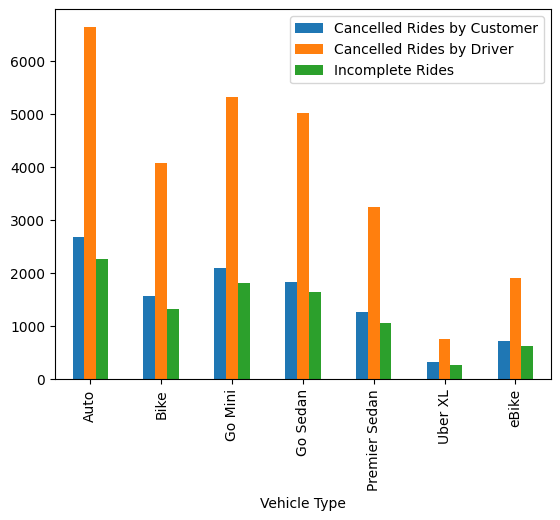

In [18]:
viajes_incompletos.drop('Total').plot(kind='bar')

In [19]:
# Uniendo las atributos de fecha y tiempo, para luego desglosarlo en mes, dia y hora
df['full_time'] = df['Date'] + ' ' + df['Time']
df['full_time'] = pd.to_datetime(df['full_time'])
df['full_time'].sort_index(inplace=True)

# Desglosando por mes, dia y hora

df['month'] = df['full_time'].dt.month
df['day'] = df['full_time'].dt.day_of_week
df['hour'] = df['full_time'].dt.hour

/var/folders/cl/ps2x_0zj5ksbpsbx7l28s8gc0000gn/T/ipykernel_33236/1313251400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_time'] = df['Date'] + ' ' + df['Time']
/var/folders/cl/ps2x_0zj5ksbpsbx7l28s8gc0000gn/T/ipykernel_33236/1313251400.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_time'] = pd.to_datetime(df['full_time'])
/var/folders/cl/ps2x_0zj5ksbpsbx7l28s8gc0000gn/T/ipykernel_33236/1313251400.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [20]:
# eliminamos los atributos de date y time

df = df.drop(columns=['Date', 'Time'])

In [21]:
# Analizaremos el tiempo promedio de espera por ambas partes, ya que influye en saber si el viaje va a ser candelado
print('Tiempo promedio de espera del conductor')
print(df['Avg CTAT'].mean())

print('Tiempo promedio de espera del usuario')
print(df['Avg VTAT'].mean())

Tiempo promedio de espera del conductor
29.149636274509803
Tiempo promedio de espera del usuario
8.456351971326166


<Axes: >

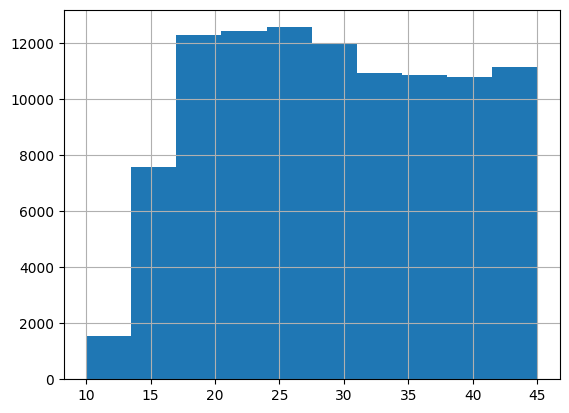

In [22]:
df['Avg CTAT'].hist()

<Axes: >

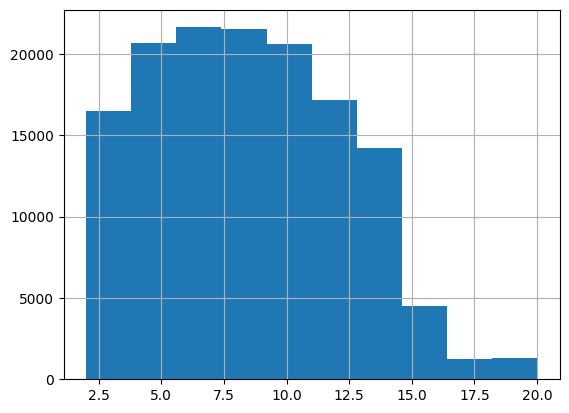

In [23]:
df['Avg VTAT'].hist()

In [24]:
# Analizando la distribucion de los datos de ambas graficas, obtamos por reemplazar los vacios con la media de ambos
df['Avg VTAT'] = df['Avg VTAT'].fillna(df['Avg VTAT'].mean())
df['Avg CTAT'] = df['Avg CTAT'].fillna(df['Avg CTAT'].mean())

In [25]:
# distancia = 0 con sin_distancia=1 → probablemente cancelación.
# distancia > 0 con sin_distancia=0 → viaje realizado.
df["sin_distancia"] = df["Ride Distance"].isna().astype(int)
df["Ride Distance"] = df["Ride Distance"].fillna(0)

In [26]:
df['sin_precio'] = df['Booking Value'].isna().astype(int)
df['Booking Value'] = df['Booking Value'].fillna(0)

In [27]:
df['sin_pago'] = df['Payment Method'].isna().astype(int)
df['Payment Method'] = df['Payment Method'].fillna(0)

In [28]:
df.isna().sum()

Booking Status                            0
Vehicle Type                              0
Pickup Location                           0
Drop Location                             0
Avg VTAT                                  0
Avg CTAT                                  0
Cancelled Rides by Customer          129000
Reason for cancelling by Customer    129000
Cancelled Rides by Driver            112500
Driver Cancellation Reason           112500
Incomplete Rides                     130500
Incomplete Rides Reason              130500
Booking Value                             0
Ride Distance                             0
Driver Ratings                        46500
Customer Rating                       46500
Payment Method                            0
usuario                                   0
full_time                                 0
month                                     0
day                                       0
hour                                      0
sin_distancia                   

### Seleccionamos las variables con el cual vamos a trabajar

In [29]:
df_trabajo = df[['Booking Status','Vehicle Type','Avg VTAT', 'Avg CTAT','Booking Value', 'Ride Distance','Payment Method','day','hour', 'sin_distancia', 'sin_pago', 'sin_precio']]

In [30]:
df_trabajo['Booking Status'] = df_trabajo['Booking Status'].apply(lambda x:1 if x in['Cancelled by Driver', 'No Driver Found', 'Cancelled by Customer ', 'Incomplete'] else 0)
df_trabajo['Booking Status'].value_counts()

/var/folders/cl/ps2x_0zj5ksbpsbx7l28s8gc0000gn/T/ipykernel_33236/3323360089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trabajo['Booking Status'] = df_trabajo['Booking Status'].apply(lambda x:1 if x in['Cancelled by Driver', 'No Driver Found', 'Cancelled by Customer ', 'Incomplete'] else 0)


Booking Status
0    103500
1     36000
Name: count, dtype: int64

In [31]:
# Codificamos 
escalado_categorica = pd.get_dummies(df_trabajo, drop_first=True)
escalado_categorica.head(5)

,Booking Status,Avg VTAT,Avg CTAT,Booking Value,Ride Distance,day,hour,sin_distancia,sin_pago,sin_precio,...,Vehicle Type_Go Mini,Vehicle Type_Go Sedan,Vehicle Type_Premier Sedan,Vehicle Type_Uber XL,Vehicle Type_eBike,Payment Method_Cash,Payment Method_Credit Card,Payment Method_Debit Card,Payment Method_UPI,Payment Method_Uber Wallet
1,1,4.9,14.0,237.0,5.73,4,18,0,0,0,...,False,True,False,False,False,False,False,False,True,False
2,0,13.4,25.8,627.0,13.58,4,8,0,0,0,...,False,False,False,False,False,False,False,True,False,False
3,0,13.1,28.5,416.0,34.02,0,17,0,0,0,...,False,False,True,False,False,False,False,False,True,False
4,0,5.3,19.6,737.0,48.21,0,22,0,0,0,...,False,False,False,False,False,False,False,False,True,False
5,0,5.1,18.1,316.0,4.85,1,9,0,0,0,...,False,False,False,False,False,False,False,False,True,False


In [32]:
# Escalaremos la variable numetica
escalado_numerico = escalado_categorica

In [33]:
# Particionamos la base de datos en train y test
feature = escalado_numerico.drop(columns=['Booking Status'])
target = escalado_numerico['Booking Status']

feature_train, feature_test, target_train, target_test = train_test_split(feature, target, test_size=0.30, random_state=123, stratify=None)

In [34]:
# Convertimos nuestro DF en 0 y 1
escalado_numerico.iloc[:,1:]= escalado_numerico.iloc[:,1:].astype(float)
escalado_numerico

/var/folders/cl/ps2x_0zj5ksbpsbx7l28s8gc0000gn/T/ipykernel_33236/3123788169.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1         4.0
2         4.0
3         0.0
4         0.0
5         1.0
         ... 
149995    0.0
149996    6.0
149997    2.0
149998    5.0
149999    6.0
Name: day, Length: 139500, dtype: float64' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  escalado_numerico.iloc[:,1:]= escalado_numerico.iloc[:,1:].astype(float)
/var/folders/cl/ps2x_0zj5ksbpsbx7l28s8gc0000gn/T/ipykernel_33236/3123788169.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1         18.0
2          8.0
3         17.0
4         22.0
5          9.0
          ... 
149995    19.0
149996    15.0
149997    10.0
149998     7.0
149999    15.0
Name: hour, Length: 139500, dtype: float64' has dtype incompatible with int3

,Booking Status,Avg VTAT,Avg CTAT,Booking Value,Ride Distance,day,hour,sin_distancia,sin_pago,sin_precio,...,Vehicle Type_Go Mini,Vehicle Type_Go Sedan,Vehicle Type_Premier Sedan,Vehicle Type_Uber XL,Vehicle Type_eBike,Payment Method_Cash,Payment Method_Credit Card,Payment Method_Debit Card,Payment Method_UPI,Payment Method_Uber Wallet
1,1,4.9,14.0,237.0,5.73,4.0,18.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,13.4,25.8,627.0,13.58,4.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,13.1,28.5,416.0,34.02,0.0,17.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,5.3,19.6,737.0,48.21,0.0,22.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0,5.1,18.1,316.0,4.85,1.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,10.2,44.4,475.0,40.08,0.0,19.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
149996,0,5.1,30.8,1093.0,21.31,6.0,15.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
149997,0,2.7,23.4,852.0,15.93,2.0,10.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
149998,0,6.9,39.6,333.0,45.54,5.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [35]:
df_trabajo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139500 entries, 1 to 149999
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Booking Status  139500 non-null  int64  
 1   Vehicle Type    139500 non-null  object 
 2   Avg VTAT        139500 non-null  float64
 3   Avg CTAT        139500 non-null  float64
 4   Booking Value   139500 non-null  float64
 5   Ride Distance   139500 non-null  float64
 6   Payment Method  139500 non-null  object 
 7   day             139500 non-null  int32  
 8   hour            139500 non-null  int32  
 9   sin_distancia   139500 non-null  int64  
 10  sin_pago        139500 non-null  int64  
 11  sin_precio      139500 non-null  int64  
dtypes: float64(4), int32(2), int64(4), object(2)
memory usage: 12.8+ MB


In [36]:
# Escalamos las variables numericas
# Se aplica el MinMaxScaler ya que con ello obtuvimos un mejor resultado en comparacion al resto
from sklearn.preprocessing import MinMaxScaler
numeric = ['Avg VTAT','Avg CTAT', 'Booking Value', 'Ride Distance', 'day', 'hour', 'sin_distancia', 'sin_pago', 'sin_precio']

scaler = MinMaxScaler()
scaler.fit(feature_train[numeric])

feature_train[numeric] = scaler.transform(feature_train[numeric])
feature_test[numeric] = scaler.transform(feature_test[numeric])

In [37]:
# Creamos una funcion para la evaluacion de modelos

def evaluar_modelo_binario(modelo, features_train, target_train, features_test, target_test, nombre_modelo='Modelo'):
    # Entrenamiento
    modelo.fit(features_train, target_train)
    
    # Predicciones
    y_pred = modelo.predict(features_test)
    y_proba = modelo.predict_proba(features_test)[:, 1]
    
    # Métricas
    auc = roc_auc_score(target_test, y_proba)
    acc = accuracy_score(target_test, y_pred)
    
    print(f'\n🔍 Evaluando: {nombre_modelo}')
    print(f'🎯 AUC-ROC: {auc:.4f}')
    print(f'📊 Exactitud: {acc:.4f}')
    print('\n📋 Reporte de clasificación:')
    print(classification_report(target_test, y_pred))
    
    # Matriz de confusión
    print('📊 Matriz de confusión:')
    display(pd.crosstab(index=target_test, columns=y_pred, rownames=['Real'], colnames=['Predicho']).style.background_gradient(cmap='Reds'))
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(target_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='blue')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('Falsos positivos')
    plt.ylabel('Verdaderos positivos')
    plt.title(f'Curva ROC - {nombre_modelo}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

    return auc, acc


🔍 Evaluando: Logistic Regression
🎯 AUC-ROC: 0.9529
📊 Exactitud: 0.9053

📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     31023
           1       0.80      0.84      0.82     10827

    accuracy                           0.91     41850
   macro avg       0.87      0.89      0.88     41850
weighted avg       0.91      0.91      0.91     41850

📊 Matriz de confusión:


Predicho,0,1
Real,,
0,28754,2269
1,1693,9134


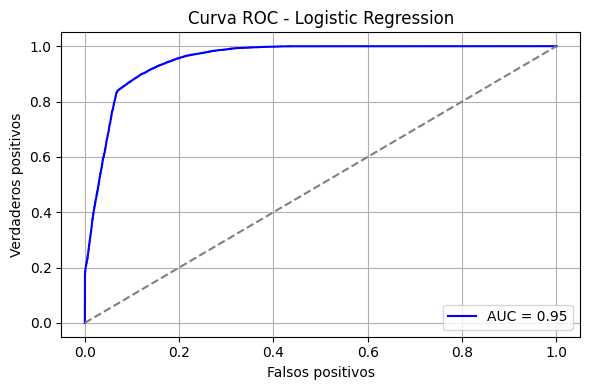

In [38]:
modelo_logreg = LogisticRegression(solver='liblinear', random_state=42)

regre_logis_auc, regre_logis_acc = evaluar_modelo_binario(modelo_logreg, feature_train, target_train, feature_test, target_test, nombre_modelo='Logistic Regression')


🔍 Evaluando: Randon Forest
🎯 AUC-ROC: 0.9657
📊 Exactitud: 0.8907

📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     31023
           1       0.70      1.00      0.83     10827

    accuracy                           0.89     41850
   macro avg       0.85      0.93      0.87     41850
weighted avg       0.92      0.89      0.90     41850

📊 Matriz de confusión:


Predicho,0,1
Real,,
0,26482,4541
1,34,10793


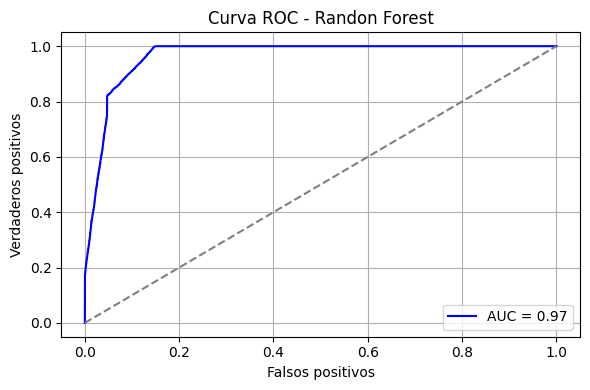

In [39]:
from sklearn.ensemble import RandomForestClassifier
modelo_randonforest = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10, min_samples_split=5,
    min_samples_leaf=2,class_weight='balanced')
rando_forest_auc, rando_forest_acc = evaluar_modelo_binario(modelo_randonforest, feature_train, target_train, feature_test, target_test, nombre_modelo='Randon Forest')

/Users/marxramosquispe/Documents/GitHub/env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:18:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔍 Evaluando: XGBClassifier
🎯 AUC-ROC: 0.9687
📊 Exactitud: 0.9165

📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     31023
           1       0.84      0.83      0.84     10827

    accuracy                           0.92     41850
   macro avg       0.89      0.89      0.89     41850
weighted avg       0.92      0.92      0.92     41850

📊 Matriz de confusión:


Predicho,0,1
Real,,
0,29360,1663
1,1833,8994


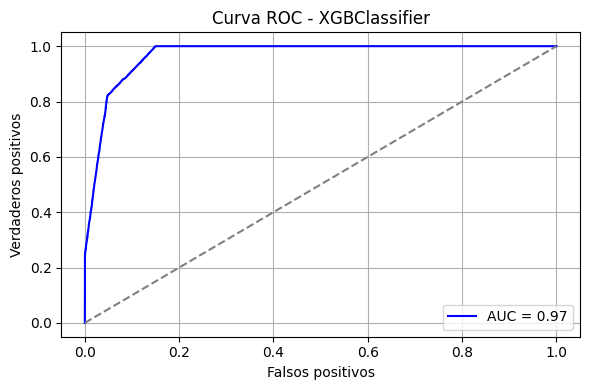

In [40]:
from xgboost import XGBClassifier
modelo_XGBC = XGBClassifier(n_estimators=200,   # número de árboles
    learning_rate=0.1,  # tasa de aprendizaje
    max_depth=6,        # profundidad máxima del árbol
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"  # evita warnings
)
XGBC_auc, XGBC_acc = evaluar_modelo_binario(modelo_XGBC, feature_train, target_train, feature_test, target_test, nombre_modelo='XGBClassifier')